# Modelo GML limpio 

In [ ]:
import pandas as pd 
import csv
from pprint import pprint
from datetime import datetime, timedelta
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import plotly.express as px
import seaborn as sns
from scipy.stats import shapiro, kstest, anderson
import plotly.graph_objects as go
import plotly.figure_factory as ff
from pySankey.sankey import sankey
from plottable import Table
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.discrete.discrete_model import NegativeBinomial
from mord import LogisticAT 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## Ultimos detalles tabla

In [41]:
censo = pd.read_csv(r'C:/Users/monic/OneDrive/Desktop/It Academmy - Data Analysis/Projecte/Python archibos buenos/tabla_madre.csv', delimiter=',', quotechar='"')
censo['LR2021 Repro'] = censo['LR2021 Repro'].replace('VU(EN/VU)', 'VU')

censo['Estatus Consolidado'] = censo['Estatus Consolidado'].replace('VU(EN/VU)', 'VU')

censo['LR2004'] = censo['LR2004'].replace('EN/VU', 'VU')

censo['Average SST month'] = pd.to_numeric(censo['Average SST month'], errors='coerce')

censo['SST change'] = pd.to_numeric(censo['SST change'], errors='coerce')

censo['Total_MPAs'] = censo['World heritage site'] + censo['SPAMI'] + censo['Marine Natura 2000 site'] + censo['Marine Natura 2000 proposed site'] + censo['MPA with a national statute'] + censo['Biosphere reserve']

censo = censo[censo['year'].isin(list(range(2007,2024)))] 

## Puebas de normalidad 

### Shapiro-Wilk

In [42]:
# Prueba de Shapiro-Wilk para el conteo de aves
data = censo['count_aves']

# Test de Shapiro-Wilk
shapiro_stat_all, shapiro_p_all = stats.shapiro(data)
print(f"Shapiro-Wilk (conteos de aves marinas):")
print(f"  Estadístico = {shapiro_stat_all:.4f}, p-value = {shapiro_p_all:.4f}")
if shapiro_p_all > 0.05:
    print("  Los datos parecen seguir una distribución normal")
else:
    print("  Los datos no parecen seguir una distribución normal")

Shapiro-Wilk (conteos de aves marinas):
  Estadístico = 0.7238, p-value = 0.0000
  Los datos no parecen seguir una distribución normal


### Kolmogorov-Smirnov

In [43]:
# Kolmogorov-Smirnov 
# Calcula la media y la desviación estándar de tus datos
mean_all = data.mean()
std_all = data.std()

kolmogorov_stat_all, kolmogorov_p_all = stats.kstest(data, 'norm', args=(mean_all, std_all))
print(f"\nKolmogorov-Smirnov (todos los conteos, comparando con N({mean_all:.2f}, {std_all:.2f})):")
print(f"  Estadístico = {kolmogorov_stat_all:.4f}, p-value = {kolmogorov_p_all:.4f}")
if kolmogorov_p_all > 0.05:
    print("  Los datos parecen seguir una distribución normal")
else:
    print("  Los datos no parecen seguir una distribución normal")

print("\n")


Kolmogorov-Smirnov (todos los conteos, comparando con N(4.41, 4.05)):
  Estadístico = 0.2156, p-value = 0.0000
  Los datos no parecen seguir una distribución normal




## Graficos para ver la normalidad

### Q-Q Plot

In [59]:
#Seleccionamos los datos que voy a usar
data_to_plot_all = censo['count_aves']

# Generar los datos para el Q-Q plot
qq_data = stats.probplot(data_to_plot_all, dist="norm")
x_qq = qq_data[0][0] # Cuantiles teóricos
y_qq = qq_data[0][1] # Cuantiles de la muestra
slope = qq_data[1][0] # Pendiente de la línea de referencia
intercept = qq_data[1][1] # Intercepto de la línea de referencia

# Crear el gráfico Q-Q
fig_qq_all = go.Figure()

# Añadir los puntos de los datos
fig_qq_all.add_trace(go.Scatter(
    x=x_qq,
    y=y_qq,
    mode='markers',
    name='Cuantiles de la Muestra',
    marker=dict(color='blue', size=8)
))

# Añadir la línea de referencia normal 
fig_qq_all.add_trace(go.Scatter(
    x=x_qq,
    y=slope * x_qq + intercept, # Línea de referencia
    mode='lines',
    name='Línea de Referencia Normal',
    line=dict(color='red', dash='dash')
))

fig_qq_all.update_layout(
    title='Gráfico Q-Q de Todos los Conteos',
    xaxis_title='Cuantiles Teóricos (Normal)',
    yaxis_title='Cuantiles de la Muestra',
    template='plotly_white',
    showlegend=True,
     width=900,  
    height=500 
)
fig_qq_all.show()

In [45]:
censo_year = censo.groupby('year')['count_aves'].sum().reset_index()

# Boxplots en facetas para cada año
fig_boxplot_facets = px.box(
    censo,
    y='count_aves', 
    x='year', 
    title='Distribución de Conteos de Aves por Año',
    labels={'Conteo': 'Conteo de Aves'},
    color='year',
    template='plotly_white',
    height=800
)
fig_boxplot_facets.update_layout(showlegend=False) 
fig_boxplot_facets.show()

# Prepara los datos para el analisis GML

In [47]:
censo_gml = censo.copy()
censo_gml = censo_gml.rename(columns={
    'SST change': 'SST_change',
    'Estatus Consolidado': 'Estatus_2021',
    'Arrossegament de fons al Mediterrani': 'Arrossegament_fons_Mediterrani',
    'Arts menors en el Mediterrani': 'Arts_menors_Mediterrani',
    'Encerclament al Mediterrani': 'Encerclament_Mediterrani',
    'Encerclament tonyina vermella al Mediterrani': 'Encerclament_tonyina_vermella_Mediterrani',
    'Palangre de fons al Mediterrani': 'Palangre_fons_Mediterrani',
    'Palangre de superficie al Mediterrani': 'Palangre_superficie_Mediterrani',
    'Total CAT': 'Total_CAT',
    'EVOLUCIÓN CATEGORÍA 2004-2021': 'Evolucion_Categoria_2004_2021',
    'Biosphere reserve': 'Biosphere_reserve',
    'MPA with a national statute': 'MPA_national_statute',
    'Marine Natura 2000 proposed site': 'Marine_Natura_2000_proposed_site',
    'Marine Natura 2000 site': 'Marine_Natura_2000_site',
    'Ramsar site': 'Ramsar_site',
    'World heritage site': 'World_heritage_site', 
    'Protection status in Catlunya': 'Protection_status_in_Catlunya'
})

censo_gml.drop(['date', 'Scientific name', 'yday', 'fecha', 'fecha_formateada', 'month', 'nombre_mes', 'Catalan name', 'Average SST 1975-2000', 'Average SST month', 'calculo', 'Ramsar_site', 'Encerclament_tonyina_vermella_Mediterrani', 'Encerclament_Mediterrani'], axis=1, inplace=True)

censo_gml

,speciesname,year,count_aves,speciesid,Ordre,Protection_status_in_Catlunya,SST_change,Arrossegament_fons_Mediterrani,Arts_menors_Mediterrani,Palangre_fons_Mediterrani,...,LR2021 Repro,Evolucion_Categoria_2004_2021,Estatus_2021,Biosphere_reserve,MPA_national_statute,Marine_Natura_2000_proposed_site,Marine_Natura_2000_site,SPAMI,World_heritage_site,Total_MPAs
75,Balearic Shearwater,2007,9,454,Procel·lariformes,Critically Endangered,2.40,331.0,700.0,56.0,...,CR,Sin Variaciones,CR,4450.05,2594.00,156.01,2146.42,247.22,135.56,9729.26
76,Balearic-/Yelkouan Shearwater,2007,4,4646,Procel·lariformes,Critically Endangered/Protected,2.40,331.0,700.0,56.0,...,CR/VU,Sin Variaciones/Desfavorable,CR/VU,4450.05,2594.00,156.01,2146.42,247.22,135.56,9729.26
77,Black-headed Gull,2007,5,200,Charadriiformes,No Evaluated,2.40,331.0,700.0,56.0,...,Sin datos,Favorable,LC,4450.05,2594.00,156.01,2146.42,247.22,135.56,9729.26
78,Cormorant,2007,12,20,Suliformes,No Evaluated,2.40,331.0,700.0,56.0,...,LC,Favorable,LC,4450.05,2594.00,156.01,2146.42,247.22,135.56,9729.26
79,Gannet,2007,13,19,Suliformes,Protected,2.40,331.0,700.0,56.0,...,Sin datos,Favorable,LC,4450.05,2594.00,156.01,2146.42,247.22,135.56,9729.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,Razorbill,2023,12,226,Charadriiformes,Vulnerable,0.84,206.0,323.0,16.0,...,Sin datos,Datos Insuficientes,DD,5251.70,49295.58,4459.98,20091.67,247.22,135.56,79481.71
1926,Sandwich Tern,2023,1,215,Charadriiformes,Vulnerable,0.84,206.0,323.0,16.0,...,VU,Desfavorable,VU,5251.70,49295.58,4459.98,20091.67,247.22,135.56,79481.71
1927,Shag,2023,9,21,Suliformes,Vulnerable,0.84,206.0,323.0,16.0,...,VU,Sin Variaciones,VU,5251.70,49295.58,4459.98,20091.67,247.22,135.56,79481.71
1928,Yelkouan Shearwater,2023,58,495,Procel·lariformes,Vulnerable,0.84,206.0,323.0,16.0,...,VU,Desfavorable,VU,5251.70,49295.58,4459.98,20091.67,247.22,135.56,79481.71


In [48]:
print("\nEstadísticas descriptivas de 'count_aves':")
print(censo_gml['count_aves'].describe())


Estadísticas descriptivas de 'count_aves':
count    1855.000000
mean        4.406469
std         4.053813
min         1.000000
25%         1.000000
50%         4.000000
75%         6.000000
max        58.000000
Name: count_aves, dtype: float64



Distribución de 'count_aves' (histograma):


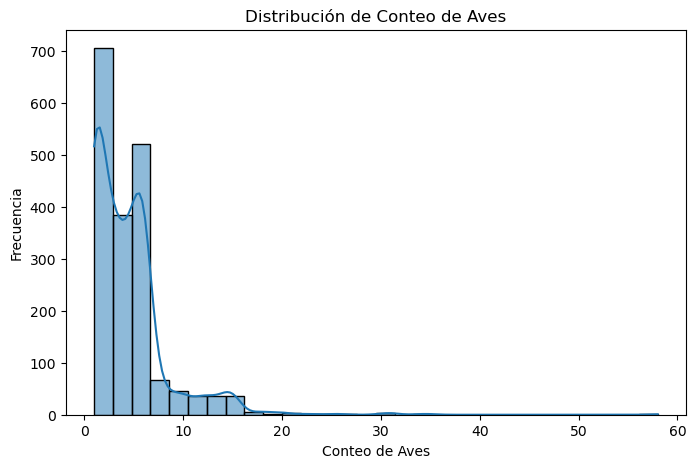

In [49]:
print("\nDistribución de 'count_aves' (histograma):")
plt.figure(figsize=(8, 5))
sns.histplot(censo_gml['count_aves'], bins=30, kde=True)
plt.title('Distribución de Conteo de Aves')
plt.xlabel('Conteo de Aves')
plt.ylabel('Frecuencia')
plt.show()

## GML para el numero de aves

Con areas marinas totales y con el cambio en la cetegoria de coservación.

In [50]:
censo_gml = censo.copy()
censo_gml = censo_gml.rename(columns={
    'SST change': 'SST_change',
    'Estatus Consolidado': 'Estatus_2021',
    'Arrossegament de fons al Mediterrani': 'Arrossegament_fons_Mediterrani',
    'Arts menors en el Mediterrani': 'Arts_menors_Mediterrani',
    'Encerclament al Mediterrani': 'Encerclament_Mediterrani',
    'Encerclament tonyina vermella al Mediterrani': 'Encerclament_tonyina_vermella_Mediterrani',
    'Palangre de fons al Mediterrani': 'Palangre_fons_Mediterrani',
    'Palangre de superficie al Mediterrani': 'Palangre_superficie_Mediterrani',
    'Total CAT': 'Total_CAT',
    'EVOLUCIÓN CATEGORÍA 2004-2021': 'Evolucion_Categoria_2004_2021',
    'Biosphere reserve': 'Biosphere_reserve',
    'MPA with a national statute': 'MPA_national_statute',
    'Marine Natura 2000 proposed site': 'Marine_Natura_2000_proposed_site',
    'Marine Natura 2000 site': 'Marine_Natura_2000_site',
    'Ramsar site': 'Ramsar_site',
    'World heritage site': 'World_heritage_site', 
    'Protection status in Catlunya': 'Protection_status_in_Catlunya'
})

censo_gml.drop(['date', 'Scientific name', 'yday', 'fecha', 'fecha_formateada', 'month', 'nombre_mes', 'Catalan name', 'Average SST 1975-2000', 'Average SST month', 'calculo', 'Ramsar_site', 'Encerclament_tonyina_vermella_Mediterrani'], axis=1, inplace=True)

censo_gml

,speciesname,year,count_aves,speciesid,Ordre,Protection_status_in_Catlunya,SST_change,Arrossegament_fons_Mediterrani,Arts_menors_Mediterrani,Encerclament_Mediterrani,...,LR2021 Repro,Evolucion_Categoria_2004_2021,Estatus_2021,Biosphere_reserve,MPA_national_statute,Marine_Natura_2000_proposed_site,Marine_Natura_2000_site,SPAMI,World_heritage_site,Total_MPAs
75,Balearic Shearwater,2007,9,454,Procel·lariformes,Critically Endangered,2.40,331.0,700.0,100.0,...,CR,Sin Variaciones,CR,4450.05,2594.00,156.01,2146.42,247.22,135.56,9729.26
76,Balearic-/Yelkouan Shearwater,2007,4,4646,Procel·lariformes,Critically Endangered/Protected,2.40,331.0,700.0,100.0,...,CR/VU,Sin Variaciones/Desfavorable,CR/VU,4450.05,2594.00,156.01,2146.42,247.22,135.56,9729.26
77,Black-headed Gull,2007,5,200,Charadriiformes,No Evaluated,2.40,331.0,700.0,100.0,...,Sin datos,Favorable,LC,4450.05,2594.00,156.01,2146.42,247.22,135.56,9729.26
78,Cormorant,2007,12,20,Suliformes,No Evaluated,2.40,331.0,700.0,100.0,...,LC,Favorable,LC,4450.05,2594.00,156.01,2146.42,247.22,135.56,9729.26
79,Gannet,2007,13,19,Suliformes,Protected,2.40,331.0,700.0,100.0,...,Sin datos,Favorable,LC,4450.05,2594.00,156.01,2146.42,247.22,135.56,9729.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,Razorbill,2023,12,226,Charadriiformes,Vulnerable,0.84,206.0,323.0,57.0,...,Sin datos,Datos Insuficientes,DD,5251.70,49295.58,4459.98,20091.67,247.22,135.56,79481.71
1926,Sandwich Tern,2023,1,215,Charadriiformes,Vulnerable,0.84,206.0,323.0,57.0,...,VU,Desfavorable,VU,5251.70,49295.58,4459.98,20091.67,247.22,135.56,79481.71
1927,Shag,2023,9,21,Suliformes,Vulnerable,0.84,206.0,323.0,57.0,...,VU,Sin Variaciones,VU,5251.70,49295.58,4459.98,20091.67,247.22,135.56,79481.71
1928,Yelkouan Shearwater,2023,58,495,Procel·lariformes,Vulnerable,0.84,206.0,323.0,57.0,...,VU,Desfavorable,VU,5251.70,49295.58,4459.98,20091.67,247.22,135.56,79481.71


In [51]:
# Código para establecer la categoría de referencia de Evolucion_Categoria_2004_2021 

# 1. Obtener todas las categorías únicas de la columna
existing_categories = censo_gml['Evolucion_Categoria_2004_2021'].unique().tolist()

# 2. Definir la categoría de referencia deseada
reference_category = 'Sin Variaciones'

# 3. Crear el nuevo orden de categorías, poniendo la de referencia primero
other_categories = sorted([cat for cat in existing_categories if cat != reference_category])
desired_category_order = [reference_category] + other_categories

# 4. Convertir la columna a tipo Categorical con el orden especificado
censo_gml['Evolucion_Categoria_2004_2021'] = pd.Categorical(
    censo_gml['Evolucion_Categoria_2004_2021'],
    categories=desired_category_order,
    ordered=False # Se usa False porque el orden no implica una jerarquía numérica
)

print(f"\nCategorías de Evolucion_Categoria_2004_2021 reordenadas. La primera es la referencia:")
print(censo_gml['Evolucion_Categoria_2004_2021'].cat.categories.tolist())


Categorías de Evolucion_Categoria_2004_2021 reordenadas. La primera es la referencia:
['Sin Variaciones', 'Datos Insuficientes', 'Desfavorable', 'Favorable', 'No Evaluada', 'Sin Variaciones/Desfavorable']


In [ ]:
print(f"Media del conteo: {censo_gml['count_aves'].mean():.2f}")
print(f"Varianza del conteo: {censo_gml['count_aves'].var():.2f}")
if censo_gml['count_aves'].var() > censo_gml['count_aves'].mean():
    print("La varianza es mayor que la media, lo que sugiere sobredispersión. NegativeBinomial es una buena elección.")
else:
    print("La varianza no es mayor que la media. Poisson podría ser suficiente o NegativeBinomial no sería la mejor opción por sobredispersión.")

# Estandarizar variables numéricas
numeric_cols = [
    'SST_change',
    'Total_MPAs',
    'Palangre_superficie_Mediterrani',
    'Palangre_fons_Mediterrani',
    'Arrossegament_fons_Mediterrani',
    'Arts_menors_Mediterrani', 
    'Encerclament_Mediterrani'
]


# Crea nuevas columnas escaladas en el DataFrame
for col in numeric_cols:
    # Calcula la media y desviación estándar para la columna
    mean_val = censo_gml[col].mean()
    std_val = censo_gml[col].std()

    # Estandariza solo si la desviación estándar es mayor que cero (para evitar división por cero)
    if std_val > 0:
        censo_gml[f'{col}_scaled'] = (censo_gml[col] - mean_val) / std_val
    else:
        print(f"Advertencia: La columna '{col}' tiene desviación estándar cero (valor constante). No se escalará.")
        censo_gml[f'{col}_scaled'] = censo_gml[col]

print("\nVariables numéricas estandarizadas.")


# Definir la fórmula del modelo con las variables escaladas
formula_scaled = (
    'count_aves ~ SST_change_scaled + Total_MPAs_scaled + '
    ' + Palangre_superficie_Mediterrani_scaled + Palangre_fons_Mediterrani_scaled +'
    'Arrossegament_fons_Mediterrani_scaled + Arts_menors_Mediterrani_scaled + Encerclament_Mediterrani_scaled + C(Evolucion_Categoria_2004_2021)'
)


#Preparar datos para el modelo
print("\nPreparando matrices de diseño...")
try:
    y, X = dmatrices(formula_scaled, data=censo_gml, return_type='dataframe')
    print("Matrices de diseño creadas exitosamente.")
except Exception as e:
    print(f"Error al crear matrices de diseño: {e}")
    print("Asegúrate de que todas las columnas en la fórmula existen en censo_gml y no hay NaNs en ellas.")
    exit()

#Ajustar el modelo NegativeBinomial
print("\n--- Ajustando el modelo NegativeBinomial con estimación de alpha ---")
try:
    nb_model = NegativeBinomial(endog=y, exog=X)
    nb_results = nb_model.fit(disp=True,  maxiter=5000)

    print(nb_results.summary())

    # El parámetro de dispersión estimado está en nb_results.params['alpha']
    print(f"\nParámetro alpha estimado por discrete.discrete_model.NegativeBinomial: {nb_results.params['alpha']:.4f}")

except Exception as e:
    print(f"\nError al ajustar el modelo NegativeBinomial: {e}")
    print("Posibles causas: Problemas de convergencia. Considera un maxiter mayor, valores iniciales, o revisar la colinealidad en variables categóricas.")


Media del conteo: 4.41
Varianza del conteo: 16.43
La varianza es mayor que la media, lo que sugiere sobredispersión. NegativeBinomial es una buena elección.

Variables numéricas estandarizadas.

Preparando matrices de diseño...
Matrices de diseño creadas exitosamente.

--- Ajustando el modelo NegativeBinomial con estimación de alpha ---
Optimization terminated successfully.
         Current function value: 2.372230
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
                     NegativeBinomial Regression Results                      
Dep. Variable:             count_aves   No. Observations:                 1855
Model:               NegativeBinomial   Df Residuals:                     1842
Method:                           MLE   Df Model:                           12
Date:               mi., 04 jun. 2025   Pseudo R-squ.:                 0.04562
Time:                        20:17:01   Log-Likelihood:                -4400.5
converged:     